In [1]:
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:

def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls, 'CROPPED') for cls in classes];
    new_complete_dest = [os.path.join(dataset_dest, cls, 'COMPLETE') for cls in classes];
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ];
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ];
    for (dest1, dest2) in zip(new_cropped_dest, new_complete_dest):
        os.makedirs(dest1);
        os.makedirs(dest2);
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (64, 64));
                img_median = cv2.medianBlur(img,5 ) # Add median filter to image
                img_yuv = cv2.cvtColor(img_median, cv2.COLOR_BGR2YUV)

                # equalize the histogram of the Y channel
                img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

                # convert the YUV image back to RGB format
                img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
                cv2.imwrite(img_des ,img);
    # Formatting Complete Images
    for (src,new_dest) in zip(complete_src, new_complete_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (256, 256));
                img_median = cv2.medianBlur(img,5 ) # Add median filter to image
                img_yuv = cv2.cvtColor(img_median, cv2.COLOR_BGR2YUV)

                # equalize the histogram of the Y channel
                img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

                # convert the YUV image back to RGB format
                img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR);
                cv2.imwrite(img_des ,img);

# Source Location for Dataset
src = '../input/cervical-cancer-largest-dataset-sipakmed';
# Destination Location for Dataset
dest = './CervicalCancer';
# Image Classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Formatting Dataset
FormatDataset(src, dest, classes);

In [3]:
root_dir = "./CervicalCancer"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

def GetDatasetSize(path, classes, main = "CROPPED"):
    num_of_image = {}
    for cls in classes:
        # Counting the Number of Files in the Folder
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls, main)));
    return num_of_image;

print(GetDatasetSize(root_dir, classes, "COMPLETE"));

{'Dyskeratotic': 223, 'Koilocytotic': 238, 'Metaplastic': 271, 'Parabasal': 108, 'Superficial-Intermediate': 126}


In [4]:
def TrainValTestSplit(root_dir, classes_dir, main = "CROPPED", val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('training/' + cls)
        os.makedirs('testing/' + cls)
        os.makedirs('validation/' + cls)
    
        # Folder to copy images from
        src = os.path.join(root_dir, cls, main);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'training/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'validation/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'testing/' + cls)
        print();
        

# Preforming Train / Validation / Test Split
root_dir = "./CervicalCancer"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

Dyskeratotic :
Total images:  813
Training:  569
Validation:  122
Testing:  122

Koilocytotic :
Total images:  825
Training:  577
Validation:  124
Testing:  124

Metaplastic :
Total images:  793
Training:  555
Validation:  119
Testing:  119

Parabasal :
Total images:  787
Training:  550
Validation:  118
Testing:  119

Superficial-Intermediate :
Total images:  831
Training:  581
Validation:  125
Testing:  125



In [5]:
#SIPaKMeD Veritabanı, Pap smear slaytlarının 966 küme hücre görüntüsünden manuel olarak kırpılmış izole edilmiş hücrelerin 4049 görüntüsünden oluşur. 
#Bu görüntüler, optik mikroskoba uyarlanmış bir CCD kamera aracılığıyla elde edildi. 
#Hücre görüntüleri normal, anormal ve iyi huylu hücreleri içeren beş kategoriye ayrılmıştır.


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications import imagenet_utils
import tensorflow
import cv2

from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg19 import VGG19
#from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.efficientnet import EfficientNetB7
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

imgdata = []
imgoutdata = []

labels = []
compressed_img_size = 80
celltypes = ['im_Koilocytotic', 'im_Metaplastic', 'im_Dyskeratotic', 'im_Parabasal', 'im_Superficial-Intermediate']
path = ["../input/cervical-cancer-largest-dataset-sipakmed/" + celltype  + "/" + celltype + "/CROPPED/" for celltype in celltypes]


#Sadece görüntüyü okuma kısmı hazır kod filter kısmını okuduğum makaledeki gibi medyan filter ile değiştirip test etmeyi planlıyorum.

# Low pass filter
#LOW_PASS_FILTER = False
# High pass filter
#HIGH_PASS_FILTER = False

cur_label = -1
for celltype in path:
    cur_label += 1 
    cellimages = os.listdir(celltype)
    for cellimage in cellimages:
        if cellimage.lower().endswith(".bmp"):
            # Mark each cell with a cell type
            labels.append(cur_label)
            img = cv2.imread(celltype+cellimage)
            img = np.array(Image.fromarray(img, 'RGB').resize((compressed_img_size, compressed_img_size)))
            #if LOW_PASS_FILTER:
            #    img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
            #elif HIGH_PASS_FILTER:
            #    img = img - cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT) + 127
            img_median = cv2.medianBlur(img,5 ) # Add median filter to image
            img_yuv = cv2.cvtColor(img_median, cv2.COLOR_BGR2YUV)

            # equalize the histogram of the Y channel
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

            # convert the YUV image back to RGB format
            img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
            
            imgdata.append(img)

            imgoutdata.append(img_output)

labels = np.array(labels)
imgdata = np.array(imgdata)
print(labels,imgdata)


[0 0 0 ... 4 4 4] [[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [215 172 240]
   [211 170 242]
   [212 174 245]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [214 170 235]
   [212 170 243]
   [218 180 244]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [209 167 229]
   [215 173 243]
   [222 185 244]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[214 196 199]
   [214 195 195]
   [210 194 196]
   ...
   [214 199 206]
   [213 200 203]
   [214 199 201]]

  [[215 197 196]
   [214 195 194]
   [208 195 196]
   ...
   [216 198 207]
   [214 199 204]
   [215 197 203]]

  [[214 197 195]
   [212 194 195]
   [207 192 194]
   ...
   [215 200 204]
   [217 19

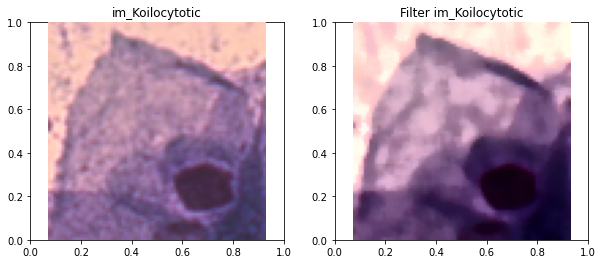

In [6]:
def show_the_image(i):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
      
    # showing image
    plt.imshow(imgdata[i])
    plt.axis('off')
    plt.title(celltypes[labels[i]])
                       
                       
    fig.add_subplot(rows, columns, 2)
      
    # showing image
    plt.imshow(imgoutdata[i])
    plt.axis('off')
    plt.title("Filter "+celltypes[labels[i]])

    
show_the_image(3)

In [7]:
#https://keras.io/api/applications/ bu linkten modellerin performanslarını inceleyip modelleri seçtim.
#include_top false değerinde sadece özellik çıkarma katmanları modele dahil edildi.Sanırım sorduğunuz soru bu kısımdı.

model_densenet = DenseNet201(weights = 'imagenet', include_top = False ,input_shape=(64,64,3))
#model_nasnet = NASNetMobile(weights = 'imagenet', include_top = False)
#model_mobilenet = MobileNetV2(weights = 'imagenet', include_top = False)
#model_ıncepnet = InceptionResNetV2(weights = 'imagenet', include_top = False)
#model_resnet = ResNet152V2(weights = 'imagenet', include_top = False)
#model_vgg = VGG19(weights = 'imagenet', include_top = False)


#features_nasnet = model_nasnet.predict(imgdata, batch_size=32)
#features_densenet = model_densenet.predict(imgdata, batch_size=32)
#features_mobilenet = model_mobilenet.predict(imgdata, batch_size=32)
#features_ıncepnet = model_ıncepnet.predict(imgdata, batch_size=32)
#features_resnet = model_resnet.predict(imgdata, batch_size=32)
#features_vgg = model_vgg.predict(imgdata, batch_size=32)

#print(features_densenet.shape)
#print(features_nasnet.shape)
#print(features_mobilenet.shape)
#print(features_ıncepnet.shape)
#print(features_resnet.shape)
#print(features_vgg.shape)

2023-01-27 04:29:32.952587: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


74850304/74836368 [==============================] - 1s 0us/step


In [8]:
# Importing Keras for Image Classification
import keras
from tensorflow.keras import layers
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


In [9]:

# CNN Model 
model = Sequential() 
model.add(model_densenet)
model.add(Flatten())

model.add(layers.Dense(units=64, activation='relu'))

model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(units=5, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 2, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                491584    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 18,813,893
Trainable params: 18,584,837
Non-trainable params: 229,056
_________________________________________________________________


In [10]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(directory= "./training", target_size=(64, 64), batch_size=100, class_mode = 'categorical')
val_data = val_datagen.flow_from_directory(directory= "./validation", target_size=(64, 64), batch_size=100, class_mode = 'categorical')
test_data = test_datagen.flow_from_directory(directory= "./testing", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 2832 images belonging to 5 classes.
Found 608 images belonging to 5 classes.
Found 609 images belonging to 5 classes.


In [24]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

In [25]:
# Fitting the Model
cnn = model.fit(train_data, 
                  steps_per_epoch= 28, 
                  epochs= 80,
                  validation_data= val_data, 
                  validation_steps= 6,
                  callbacks = call_back)

Epoch 1/80
28/28 [==============================] - 102s 4s/step - loss: 0.2582 - accuracy: 0.9187 - val_loss: 1.5294 - val_accuracy: 0.7417

Epoch 00001: val_accuracy did not improve from 0.79000
Epoch 2/80
28/28 [==============================] - 100s 4s/step - loss: 0.2390 - accuracy: 0.9136 - val_loss: 1.6714 - val_accuracy: 0.7017

Epoch 00002: val_accuracy did not improve from 0.79000
Epoch 3/80
28/28 [==============================] - 97s 3s/step - loss: 0.2206 - accuracy: 0.9283 - val_loss: 1.8189 - val_accuracy: 0.7267

Epoch 00003: val_accuracy did not improve from 0.79000
Epoch 4/80
28/28 [==============================] - 98s 4s/step - loss: 0.1871 - accuracy: 0.9418 - val_loss: 1.5894 - val_accuracy: 0.7200

Epoch 00004: val_accuracy did not improve from 0.79000
Epoch 5/80
28/28 [==============================] - 97s 3s/step - loss: 0.2174 - accuracy: 0.9323 - val_loss: 0.9133 - val_accuracy: 0.8017

Epoch 00005: val_accuracy improved from 0.79000 to 0.80167, saving model 

In [30]:
accuracy = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy*100} %")

The accuracy of your model is = 76.68308615684509 %
